# Курсовой проект

План курсового проекта

1. Подключение библиотек и скриптов
2. Загрузка данных
3. EDA
4. Обработка выбросов и пропусков
5. Отбор признаков
6. Построение новых признаков
7. Разбиение на train и test
8. Построение модели
9. Прогнозирование на тестовом датасете

1. Подключение библиотек и скриптов

In [117]:
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [118]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [119]:
import warnings
warnings.filterwarnings('ignore')

In [120]:
matplotlib.rcParams.update({'font.size': 14})

2. Загрузка данных

Описание датасета

Id - идентификационный номер квартиры\
DistrictId - идентификационный номер района\
Rooms - количество комнат\
Square - площадь\
LifeSquare - жилая площадь\
KitchenSquare - площадь кухни\
Floor - этаж\
HouseFloor - количество этажей в доме\
HouseYear - год постройки дома\
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности\
Social_1, Social_2, Social_3 - социальные показатели местности\
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья\
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров\
Price - цена квартиры\

In [121]:
os.chdir('\ProgramData\GB')

In [122]:
train_df = pd.read_csv('train.csv')

In [123]:
test_df = pd.read_csv('test.csv')

In [124]:
submit = pd.read_csv('sample_submission.csv')

3. EDA

In [125]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [126]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [127]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [128]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [129]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [130]:
train_df.select_dtypes(include='object').columns.tolist()
test_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [131]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [132]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [133]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [134]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

4. Обработка выбросов и пропусков

Что можно делать с ними?

1) Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем).\
2) Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.).\
3) Делать/не делать дополнительную фичу.\
4) Ничего не делать.\

Построим графики для анализа данных и поиска выбросов.

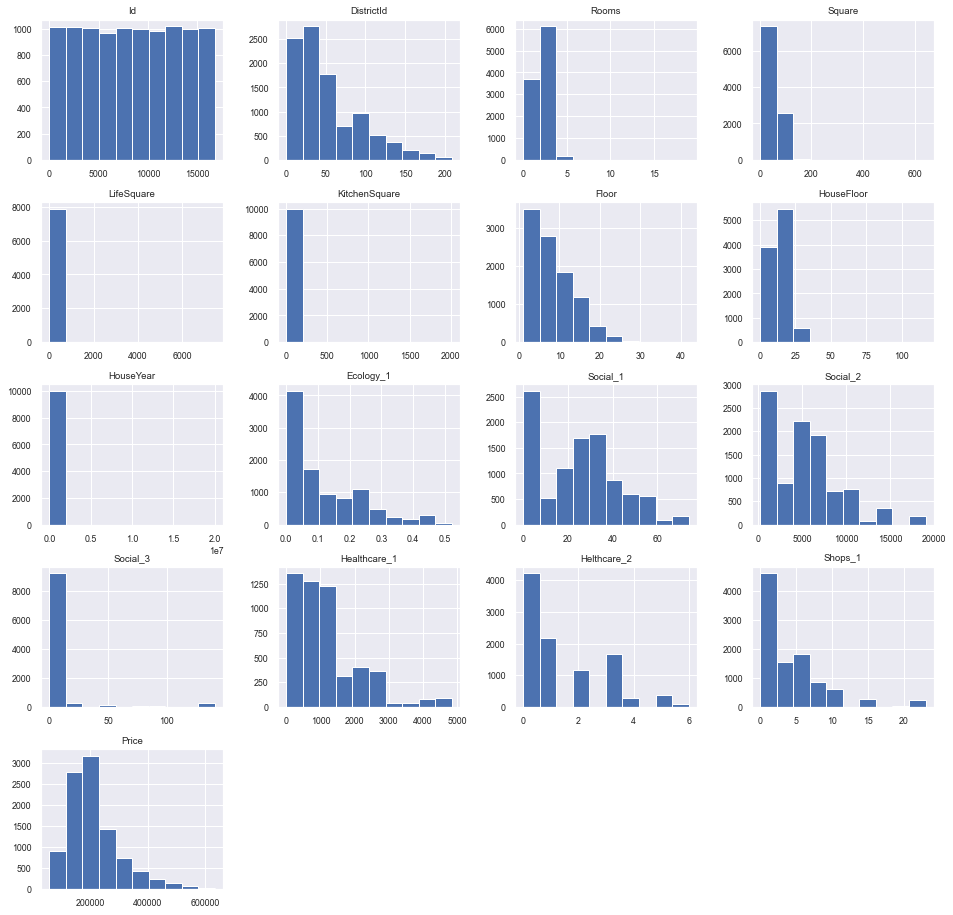

In [135]:
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

In [136]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [137]:
rooms_median = train_df['Rooms'].median()
condition = (train_df['Rooms'].isna()) \
             | (train_df['Rooms'] >= 6)
        
train_df.loc[condition, 'Rooms'] = rooms_median
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

In [138]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [139]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [140]:
train_df['HouseFloor'].quantile(.975), train_df['HouseFloor'].quantile(.025)

(25.0, 0.0)

In [141]:
house_floor_median = train_df['HouseFloor'].median()
condition = (train_df['HouseFloor'].isna()) \
             | (train_df['HouseFloor'] > train_df['HouseFloor'].quantile(.975))
        
train_df.loc[condition, 'HouseFloor'] = house_floor_median

In [142]:
train_df['HouseFloor'].value_counts()

17.0    2331
9.0     1389
12.0    1074
5.0     1031
14.0     625
16.0     576
1.0      497
25.0     374
22.0     343
0.0      269
24.0     176
8.0      141
10.0     135
4.0      134
3.0      127
15.0     123
19.0     108
20.0     105
18.0      89
13.0      87
7.0       59
6.0       58
2.0       48
23.0      40
21.0      33
11.0      28
Name: HouseFloor, dtype: int64

In [143]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

In [144]:
train_df['Floor'].quantile(.975), train_df['Floor'].quantile(.025)

(21.0, 2.0)

In [145]:
floor_median = train_df['Floor'].median()
condition = (train_df['Floor'].isna()) \
             | (train_df['Floor'] > train_df['Floor'].quantile(.975))
        
train_df.loc[condition, 'Floor'] = floor_median

In [146]:
train_df['Floor'].value_counts()

7     957
4     949
5     876
3     872
6     802
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
Name: Floor, dtype: int64

In [147]:
house_floor_condition = train_df['HouseFloor'] < train_df['Floor']
train_df.loc[house_floor_condition, 'HouseFloor'] = train_df.loc[house_floor_condition, 'Floor']

In [148]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [149]:
train_df['HouseYear'].quantile(.95), train_df['HouseYear'].quantile(.05)

(2017.0, 1961.0)

In [150]:
current_year = datetime.now().year

train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

In [151]:
train_df['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1910       1
1928       1
1916       1
1947       1
1914       1
Name: HouseYear, Length: 96, dtype: int64

In [152]:
train_df['KitchenSquare'].value_counts(ascending=False)

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [153]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.1)

(13.0, 1.0)

In [154]:
kitchen_square_median = train_df['KitchenSquare'].median()
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = kitchen_square_median

train_df.loc[train_df['KitchenSquare'] <= 4, 'KitchenSquare'] = 4

In [155]:
train_df['KitchenSquare'].value_counts()

4.0     3222
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

In [156]:
train_df.fillna(0, inplace=True)
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

test_df.fillna(0, inplace=True)
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [157]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [158]:
train_df.head(15)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,0.000000,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,0.000000,4.0,10,22.0,1977,0.007122,1,1,1,264,0,0.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0.0,0,6,1,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,1,1,35,5776,1,2078.0,2,4,1,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,1,1,24,4860,1,80.0,0,3,1,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,1,1,37,7687,11,176.0,5,5,1,326174.175191
8,9951,1,1.0,46.887892,44.628132,4.0,12,20.0,1977,0.007122,1,1,1,264,0,0.0,0,1,1,160400.401732
9,8094,6,3.0,79.867477,75.085125,4.0,3,17.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,194756.023945


5. Отбор признаков

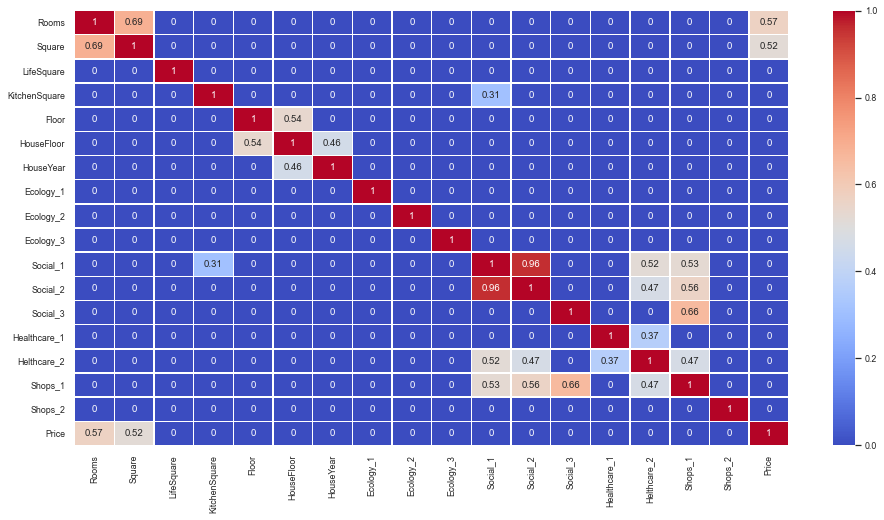

In [159]:
train_df_corr = train_df.corr()
import seaborn as sns
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

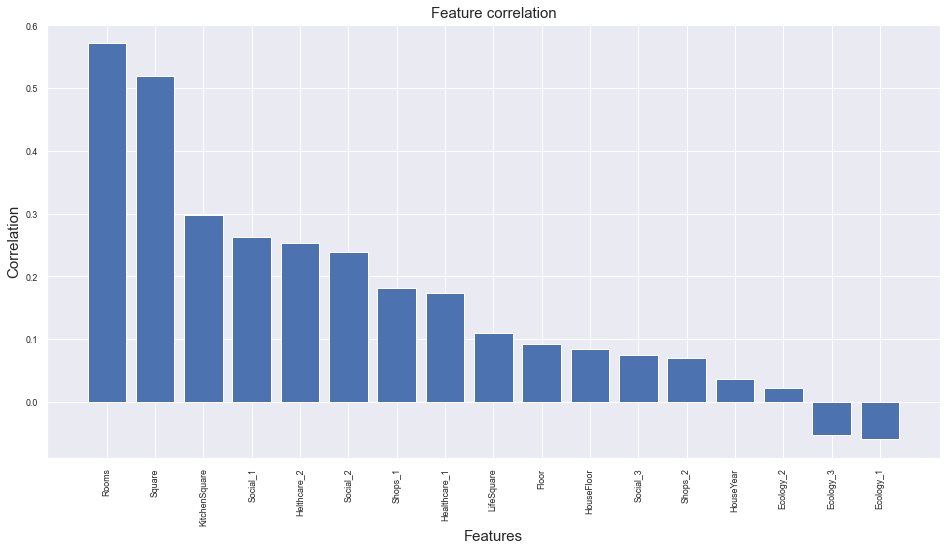

In [160]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

6. Построение новых признаков

In [161]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        
    def fit(self, train_df):
        # средние значения по году, кв. м, и цене за кв. м в зависимости от района
        self.districts_median_year = train_df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict() 
        
        self.districts_density = train_df.groupby(['DistrictId'])['Square'].agg('median').to_dict() 
        
        self.district_price_per_square = train_df.groupby(['DistrictId'])['Price'].agg('median') \
        / train_df.groupby(['DistrictId'])['Square'].agg('median') 
        
    
    def new_features(self, train_df):
        # Возраст района     
        train_df['DistrictYear'] = train_df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = train_df['DistrictYear'].median()
        train_df['DistrictYear'].fillna(self.median_district_year, inplace=True)
        

        # Средняя цена за кв. м в зависимости от района
        train_df['DistrictDensity'] = train_df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = train_df['DistrictDensity'].median()
        train_df['DistrictDensity'].fillna(self.median_district_density, inplace=True)
        

        # Средняя цена за кв. м в зависимости от района 
        self.district_price_per_square.to_dict()
        train_df['DistrictPrice'] = train_df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = train_df['DistrictPrice'].median()
        train_df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)

        
        # Шкалирование и объединение Social, Healthcare в одну фичу
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(train_df[['Social_1', 'Social_2', 'Social_3']]))
        train_df['Social'] = pca.fit_transform(social_scaled)
        
        healthcare_scaled = pd.DataFrame(scaler.fit_transform(train_df[['Healthcare_1', 'Helthcare_2']]))
        train_df['Healthcare'] = pca.fit_transform(healthcare_scaled)
        
        train_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)
        
        return train_df

In [162]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
test_df = features_gen.new_features(test_df)

7. Разбиение на train и test

In [163]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)

In [164]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Social,Healthcare
3898,722,9,3.0,77.400511,47.487366,10.0,13,17.0,1993,0.069753,53,13670,4,0.0,11,1990.0,56.763182,3282.193776,-0.788374,-0.603482
9112,12323,27,3.0,82.519599,0.000000,4.0,6,12.0,1977,0.017647,2,469,0,0.0,0,1977.0,54.755388,2669.535159,-1.619764,-0.843591
9296,16690,57,1.0,42.159001,20.828892,8.0,8,12.0,2006,0.133215,49,11395,3,1406.0,4,1991.0,50.373114,3976.163496,-0.993276,1.122466
4508,12005,45,2.0,46.224004,34.399373,5.0,3,5.0,1962,0.014423,19,3806,4,0.0,3,1977.0,61.372365,5079.590016,-0.811438,-0.843591
6833,2362,27,3.0,82.489099,51.510559,4.0,12,12.0,2018,0.072158,2,629,1,0.0,0,1977.0,54.755388,2669.535159,-1.419461,-0.843591


8. Построение модели

In [165]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8704646775058819
0.7548456215192219


In [166]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
3,Square,0.276932
17,DistrictPrice,0.184125
2,Rooms,0.095958
4,LifeSquare,0.095212
10,Social_1,0.054702
11,Social_2,0.043019
8,HouseYear,0.028328
18,Social,0.028228
12,Social_3,0.025832
5,KitchenSquare,0.024956


9. Прогнозирование на тестовом датасете

In [167]:
test_df.shape

(5000, 20)

In [168]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Social,Healthcare
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,4378,0,1036.0,1,1977.0,46.971646,4431.704675,-1.654285,0.320454
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,629,1,0.0,0,1977.0,56.667328,2859.977368,-1.462656,-0.839097
2,960,27,2.0,59.463678,0.000000,9.0,19,19.0,1977,0.211401,9,1892,0,0.0,1,1977.0,54.755388,2669.535159,-1.659865,-0.839097
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,475,0,0.0,0,1977.0,53.949294,2109.194622,-1.662911,-0.839097
4,746,74,1.0,53.837056,0.000000,1.0,8,17.0,1977,0.309479,35,7715,4,990.0,6,1977.0,56.148572,3483.810063,-0.847631,0.054476


In [169]:
predictions = gb_model.predict(test_df)
predictions

array([166213.62105116, 114449.08949684, 137394.0063858 , ...,
       149932.55823802, 192131.12165119, 288358.05657808])

In [170]:
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [171]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166213.621051
1,5925,114449.089497
2,960,137394.006386
3,3848,88529.699991
4,746,181369.182159


In [172]:
submit.to_csv('rf_submit7.csv', index=False)